In [1]:
# allow the notebook to access the parent directory so we can import the other modules
# https://stackoverflow.com/a/35273613
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Data Preparation
-----

### Constants and Folder Paths

In [2]:
import os
dataset_folder_path = os.path.join("..", "files", "dataset")

In [3]:
from data.DataSet import DataSet
dataset = DataSet()
dataset.load(dataset_folder_path, test_set_percentage=0.2, validation_set_percentage=0.3333)

print("Training Data Len:", len(dataset.train_data))
print("Validation Data Len:", len(dataset.valid_data))
print("Test Data Len:", len(dataset.test_data))

36 files found!
Training Data Len: 1900
Validation Data Len: 1000
Test Data Len: 700


### Data Preprocessing

In [4]:
NUM_SAMPLES = 50
ANGLES_TO_ROTATE = [5, 10, 15, 45, -5, -10, -15, -45]

In [5]:
from utils.preprocessing import *
from functools import partial
dataset.apply(apply_mean_centering)
dataset.apply(apply_unit_distance_normalization)
dataset.apply(partial(spline_interpolate_and_resample, num_samples=NUM_SAMPLES))
dataset.expand_many(partial(rotate_digit, degrees=ANGLES_TO_ROTATE))
dataset.expand(reverse_digit_sequence)

print("Training Data Len:", len(dataset.train_data))
print("Validation Data Len:", len(dataset.valid_data))
print("Test Data Len:", len(dataset.test_data))

Training Data Len: 34200
Validation Data Len: 18000
Test Data Len: 12600


### Split Dataset into *Train*, *Valid*, and *Test*

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train = np.array(dataset.train_data)
X_valid = np.array(dataset.valid_data)
X_test = np.array(dataset.test_data)

# Convert labels to numpy array and OneHot encode them
encoder, Y_train, Y_valid, Y_test = dataset.onehot_encode_labels()

print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", Y_train.shape)
print("Validation Data Shape:", X_valid.shape)
print("Validation Labels Shape:", Y_valid.shape)
print("Test Data Shape:", X_test.shape)
print("Test Labels Shape:", Y_test.shape)

Training Data Shape: (34200, 50, 2)
Training Labels Shape: (34200, 10)
Validation Data Shape: (18000, 50, 2)
Validation Labels Shape: (18000, 10)
Test Data Shape: (12600, 50, 2)
Test Labels Shape: (12600, 10)


----------
# Neural Network Setup and Training
----------

## **Regularized 3x512 GRU**

### Parameters

In [22]:
PARAM_NUM_EPOCHS = 60
PARAM_BATCH_SIZE = 500

### Setup Model

In [23]:
from models.regularized_3x512_gru import Regularized3x512GRU
import os.path

mymodel = Regularized3x512GRU(X_train.shape[1:], output_path=os.path.join("..", "files"))
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.initialize()
print(mymodel)



----------

Optimizer: <class 'keras.optimizers.Nadam'>
Batch Size: 500
Number of Epochs: 60

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 50, 512)           791040    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 50, 512)           1575936   
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
______________________________________________

#### Save Model Summary

In [24]:
mymodel.save_summary(dataset.get_recorded_operations())
mymodel.save_config()

Summary saved to ../files/checkpoints/1526508141.0371778/summary.txt
Model config saved to ../files/checkpoints/1526508141.0371778/model.txt


### Train Model

In [25]:
mymodel.train(X_train, Y_train, X_valid, Y_valid)

Train on 34200 samples, validate on 18000 samples
Epoch 1/60
34200/34200 [==============================] - 37s 1ms/step - loss: 1.9257 - categorical_accuracy: 0.5194 - val_loss: 0.9505 - val_categorical_accuracy: 0.7853

Epoch 00001: val_categorical_accuracy improved from -inf to 0.78528, saving model to ../files/checkpoints/1526508141.0371778/regularized_3x512_gru-01-0.785.hdf5
Epoch 2/60
34200/34200 [==============================] - 38s 1ms/step - loss: 0.4605 - categorical_accuracy: 0.9219 - val_loss: 0.5139 - val_categorical_accuracy: 0.8993

Epoch 00002: val_categorical_accuracy improved from 0.78528 to 0.89928, saving model to ../files/checkpoints/1526508141.0371778/regularized_3x512_gru-02-0.899.hdf5
Epoch 3/60
34200/34200 [==============================] - 37s 1ms/step - loss: 0.4220 - categorical_accuracy: 0.9249 - val_loss: 0.4448 - val_categorical_accuracy: 0.9104

Epoch 00003: val_categorical_accuracy improved from 0.89928 to 0.91044, saving model to ../files/checkpoints/


Epoch 00031: val_categorical_accuracy did not improve
Epoch 32/60
34200/34200 [==============================] - 37s 1ms/step - loss: 0.0270 - categorical_accuracy: 0.9955 - val_loss: 0.4059 - val_categorical_accuracy: 0.9283

Epoch 00032: val_categorical_accuracy did not improve
Epoch 33/60
34200/34200 [==============================] - 38s 1ms/step - loss: 0.0214 - categorical_accuracy: 0.9973 - val_loss: 0.3296 - val_categorical_accuracy: 0.9403

Epoch 00033: val_categorical_accuracy improved from 0.93722 to 0.94028, saving model to ../files/checkpoints/1526508141.0371778/regularized_3x512_gru-33-0.940.hdf5
Epoch 34/60
34200/34200 [==============================] - 38s 1ms/step - loss: 0.0219 - categorical_accuracy: 0.9970 - val_loss: 0.2870 - val_categorical_accuracy: 0.9407

Epoch 00034: val_categorical_accuracy improved from 0.94028 to 0.94067, saving model to ../files/checkpoints/1526508141.0371778/regularized_3x512_gru-34-0.941.hdf5
Epoch 35/60
34200/34200 [===================

### Evaluate Model

#### Test Set Accuracy

In [26]:
test_score = tuple(mymodel.model.evaluate(X_test, Y_test))
print("Test Loss: %.3f, Test Acc: %.3f%%" % (test_score[0], test_score[1] * 100))

12600/12600 [==============================] - 11s 844us/step
Test Loss: 0.358, Test Acc: 93.349%


#### Recall, Precision, F1_Score on Test set

In [28]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_test = mymodel.model.predict_classes(X_test, verbose=1)
rpf_test = get_evaluation_metrics(Y_test, Y_predicted_test)
rpf_test

12600/12600 [==============================] - 9s 723us/step


,recall,precision,f1 score,#
0,0.990074,0.950000,0.969623,1260.0
1,0.983633,0.953968,0.968574,1260.0
2,0.876525,0.969048,0.920467,1260.0
3,0.988737,0.975397,0.982022,1260.0
4,0.948606,0.864286,0.904485,1260.0
5,0.766583,0.972222,0.857243,1260.0
6,0.978571,0.978571,0.978571,1260.0
7,0.974615,0.853175,0.909860,1260.0
8,0.957970,0.958730,0.958350,1260.0
9,0.931212,0.859524,0.893933,1260.0


Average F1 Score for Test Set

In [29]:
rpf_test.mean()

recall          0.939653
precision       0.933492
f1 score        0.934313
#            1260.000000
dtype: float64

#### Recall, Precision, F1_Score on Validation set

In [30]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_valid = mymodel.model.predict_classes(X_valid, verbose=1)
rpf_valid = get_evaluation_metrics(Y_valid, Y_predicted_valid)
rpf_valid

18000/18000 [==============================] - 13s 727us/step


,recall,precision,f1 score,#
0,0.947812,0.998889,0.972681,1800.0
1,0.874118,0.895000,0.884436,1800.0
2,0.903292,0.975556,0.938034,1800.0
3,0.976592,0.996667,0.986527,1800.0
4,0.965538,0.871667,0.916204,1800.0
5,0.917160,0.947222,0.931949,1800.0
6,0.962514,0.927222,0.944539,1800.0
7,0.923571,0.879444,0.900968,1800.0
8,0.944475,0.954444,0.949434,1800.0
9,0.975694,0.936667,0.955782,1800.0


Average F1 Score for Validation Set

In [31]:
rpf_valid.mean()

recall          0.939077
precision       0.938278
f1 score        0.938055
#            1800.000000
dtype: float64

##### Increase default plotsize for matplotlib

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

#### Plot Validation Set Confusion Matrix

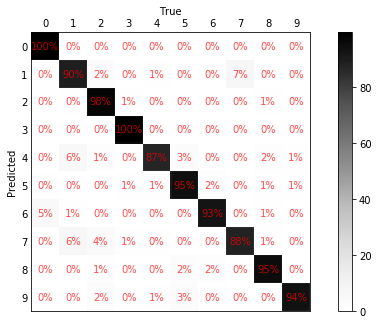

In [32]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_valid, Y_predicted_valid, plot=True)

#### Plot Test Set Confusion Matrix

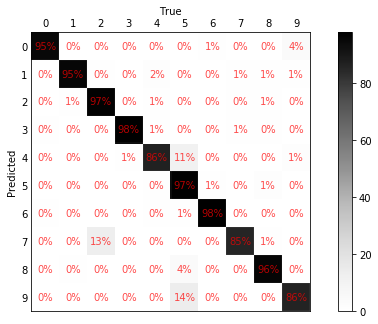

In [33]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_test, Y_predicted_test, plot=True)

# Backup Code
-----

In [11]:
from models.regularized_3x512_gru import Regularized3x512GRU
import os.path
from keras.models import load_model
TRAINED_MODEL = os.path.join("..", "files", "checkpoints", "1525696834.4091375", "regularized_3x512_gru-30-0.97.hdf5")

mymodel = Regularized3x512GRU(X_train.shape[1:], output_path=os.path.join("..", "files"))
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.disable_callbacks()
mymodel.model = load_model(TRAINED_MODEL)